In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
from scipy.stats import shapiro
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [2]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [3]:
df = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')
dc1 = df[df.experimentVariant == 'Control'].value
dc2 = df[df.experimentVariant == 'Treatment'].value
# У нас нулевая гипотеза - контрольная и тестовая группа равны
# Альтернативная гипотеза - контрольная и тестовая группа не равны

In [4]:
# пробежимся по характеристикам и параметрам выборки
df.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


In [5]:
df.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [6]:
df.groupby('experimentVariant', as_index=False).agg({'value': 'count'})

,experimentVariant,value
0,Control,500
1,Treatment,500


In [7]:
df.groupby('experimentVariant', as_index=False).agg({'value': 'mean'})

,experimentVariant,value
0,Control,10.026867
1,Treatment,27.321499


In [8]:
df.groupby('experimentVariant', as_index=False).agg({'value': 'median'})

,experimentVariant,value
0,Control,10.018465
1,Treatment,10.025847


In [9]:
df.groupby('experimentVariant', as_index=False).agg({'value': 'std'})

,experimentVariant,value
0,Control,0.979377
1,Treatment,186.557011


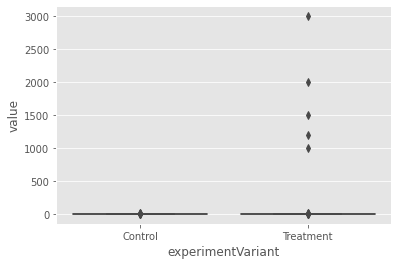

In [10]:
# Построим графики
sns.boxplot(x="experimentVariant", y="value", data=df)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


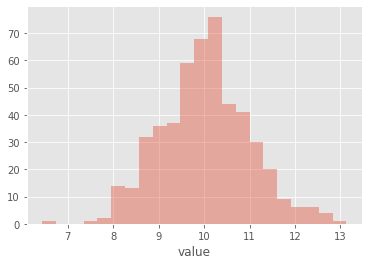

In [11]:
sns.distplot(dc1, kde=False)

In [12]:
shapiro(dc1)
# Так как нулевая гипотеза в случае Шапиро-Уилка — нормальность распределения, то здесь мы можем сделать вывод, 
# что распределение НЕ отклоняется от нормального.

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

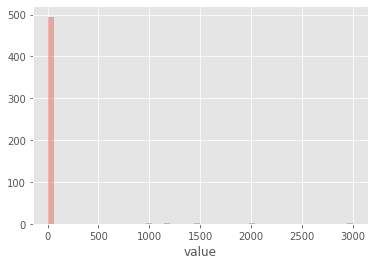

In [13]:
sns.distplot(dc2, kde=False)

In [14]:
shapiro(dc2)
# А вот здесь распределение отклоняется от нормального.

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

In [15]:
dc2.sort_values().tail(10)
# Анализ boxplot, distplot наводят на наличие выбросов. Вывод данных по возрастанию величин - подтверждают это

719      12.598569
863      12.663784
794      12.728285
695      12.817541
671      13.130346
995    1000.000000
996    1200.000000
997    1500.000000
998    2000.000000
999    3000.000000
Name: value, dtype: float64

In [16]:
# Пробежимся по методам
# U-теста Mann-Whitney
mannwhitneyu(dc1, dc2)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [17]:
# t-тест
ttest_ind(dc1, dc2)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

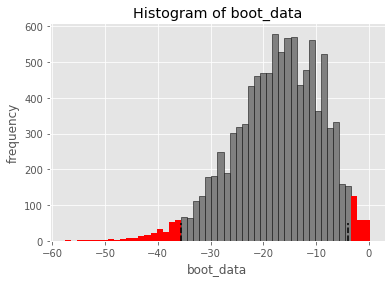

In [18]:
# Бутстрап
booted_data = get_bootstrap(
    dc1, # числовые значения первой выборки
    dc2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [19]:
booted_data["p_value"] # альфа

0.03763971671591572

In [20]:
booted_data["quants"] # ДИ не переходит через 0

,0
0.025,-35.644680
0.975,-3.892097


In [21]:
# Выводы по этой части.
# Так как у нас присутствуют выбросы, то параметрический может показать на статзначимые различия, 
# в то время как непараметрический тест значение выбросов нивелирует, что и показал тест Манна-Уитни
# t-тест и бутрстрап показывают практически одиновый p_value.
# При бутрстрапе p-value и ДИ отражают одну картину. Бывают случаи, что p-value>0.05, тогда впервую очереди смотрят на ДИ.
# переходит ли ДИ 0 или нет. 
# В нашем случае стоит выбирать или t-тест или бутрстрап. Тест Манна-Уитни из-за выбросов показал что группы равны, что неверно.
# А при выборе между  t-тест или бутрстрап, стоит отдать предпочтение бутрстрап, т.к. у него формируется ДИ, 
# что более правильно показывает картину. да и t-тест на небольших выборках требует нормального распределения, чего у нас нет.
# Ниже сделаны общие выводы по тестам...

In [22]:
# А теперь дополнительно рассмотрим ситуацию с выбросами.
# Числовая колонка содержит значения выручки по каждому пользователю за период эксперимента. Последние 5 значений это выбросы.
# При оценке дисперсии очень важно удалить выбросы. Практичный и эффективный метод –просто ограничить наблюдения разумным порогом.
df = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')
df = df.query("value<100")
dc1 = df[df.experimentVariant == 'Control'].value
dc2 = df[df.experimentVariant == 'Treatment'].value

In [23]:
# пробежимся еще раз по характеристикам
df.groupby('experimentVariant', as_index=False).agg({'value': 'count'})

,experimentVariant,value
0,Control,500
1,Treatment,495


In [24]:
df.groupby('experimentVariant', as_index=False).agg({'value': 'mean'})

,experimentVariant,value
0,Control,10.026867
1,Treatment,10.021716


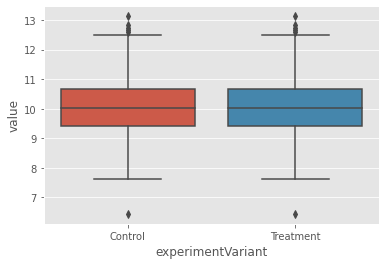

In [25]:
# Построим боксплот и увидим нормальное отображение, а не придавленное вниз
sns.boxplot(x="experimentVariant", y="value", data=df)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


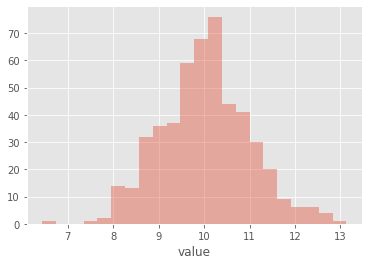

In [26]:
# Строим дистплот. Контрольная группа без изменений
sns.distplot(dc1, kde=False)

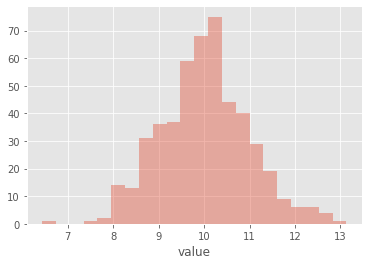

In [27]:
# Строим дисплон для тестовой группы и видим, что у него вид нормального распределения
sns.distplot(dc2, kde=False)

In [28]:
# Тест Шапиро это подтверждает
shapiro(dc2)

ShapiroResult(statistic=0.9955515265464783, pvalue=0.17188233137130737)

In [29]:
# Пробежимся по методам

In [30]:
# U-теста Mann-Whitney
mannwhitneyu(dc1, dc2)

MannwhitneyuResult(statistic=124189.5, pvalue=0.9228386264147465)

In [31]:
# t-тест
ttest_ind(dc1, dc2)

Ttest_indResult(statistic=0.0829913510759266, pvalue=0.9338751428058369)

In [32]:
# тест Колмогорова-Смирнова
ks_2samp(dc1, dc2)

KstestResult(statistic=0.004505050505050505, pvalue=1.0)

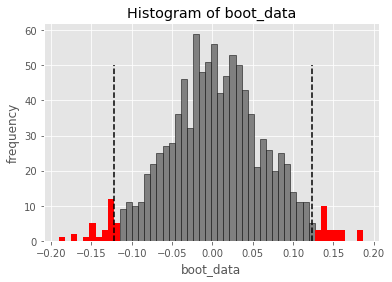

In [33]:
# Бутстрап
booted_data = get_bootstrap(
    dc1, # числовые значения первой выборки
    dc2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [34]:
booted_data["p_value"] # альфа

0.9438823818294809

In [35]:
booted_data["quants"] # ДИ переходит через 0

,0
0.025,-0.121892
0.975,0.123296


In [36]:
# Сравнив результат между тестом и контролем по всем этим кейсам приходим к выводу, что p_value почти однаковая. 
# Разброс небольшой. Итог - Мы не можем отвергнуть нулевую гипотезу о равенстве теста и контроля.

# Какой же метод выбрать? 
# Если выборка очень большая то стоит выбрать t-критерий или Манна-Уитни. 

# критерий Манна-Уитни даёт ответ на вопрос, значимо ли различаются распределения или нет. 
# Но не отвечает, где именно эта разница. И его трудно объяснить бизнесу.

# t-тест требует нормального распределения, но при Big Data это уже не является существенным.

# метод бутстрапа очень критичен к размеру выборки и к вычислительным мощностям, но он позволяет находить медиану, 
# процентили, квартили и децили, что не могут себе позволить другие методы без дополнительных манипуляций.
# Про ДИ и p_value при бутстрапе сказал ранее.
# Для нашей выборке можно рекомендовать - бутстрап.